In [1]:
#These lines are used to mount the drive when using GOOGLE COLAB. Ignore else.
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
#importing the libraries
import torch
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from torch import nn
from torch import optim
from collections import OrderedDict

from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

In [4]:
filepath = 'drive/My Drive/Colab Notebooks/Deep Learning/Deep Learning Nanodegree/Denoising Documents/denoising-dirty-documents'
train = filepath+'/train'
train_cleaned = filepath+'/train_cleaned'
test = filepath+'/test'

train_images = sorted(os.listdir(train))
train_cleaned_images = sorted(os.listdir(train_cleaned))
test_images = sorted(os.listdir(test))

print('Number of Images in train:', len(train_images))
print('Number of Images in train_cleaned:', len(train_cleaned_images))
print('Number of Images in test:', len(test_images))

Number of Images in train: 144
Number of Images in train_cleaned: 144
Number of Images in test: 72


In [0]:
#defining the transformations for tesing images
transform = transforms.Compose([transforms.Resize((320, 480)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
#contains original images
X = []
for image in train_images:
    pil_image = Image.open(train+'/'+image)
    pil_image = transform(pil_image)
    X.append(pil_image)
    
#contains cleaned training images
Y = []
for image in train_cleaned_images:
    pil_image = Image.open(train_cleaned+'/'+image)
    pil_image = transform(pil_image)
    
    Y.append(pil_image)
    
#contains test images
test_images_transformed = []
for image in test_images:
    pil_image = Image.open(test+'/'+image)
    pil_image = transform(pil_image)
    
    test_images_transformed.append(pil_image)

In [0]:
def imshow(image, ax=None, titl=None):
    if ax is None:
        fig, ax = plt.subplots()
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    ax.grid(False)
    ax.set_title(titl)
    

In [0]:
import random
from random import shuffle
random.seed(2)
#generates the dataset by combinig the original images and target images
dataset = [(X[i],Y[i]) for i in range(len(X))]
shuffle(dataset)

split_size = 0.85
index = int(len(dataset)*split_size)

train_dataset = dataset[:index]
valid_dataset = dataset[index:]


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8)

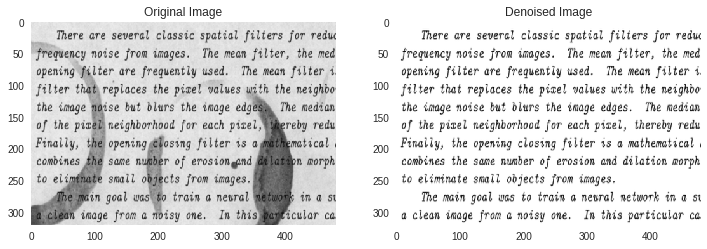

In [8]:
#visulasising the images from train_loader.
images, targets = next(iter(train_loader))
images, targets = images.numpy(), targets.numpy()

plt.figure(figsize=(12,14))
ax = plt.subplot(1,2,1)
imshow(images[2], ax, 'Original Image')

ax = plt.subplot(1,2,2)
imshow(targets[2], ax, 'Denoised Image')

In [9]:
#building model
class ConvDenoiser(nn.Module):
    
    def __init__(self):
        super().__init__();
        #defining the encoder
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2,2)
        
        #defining the decoder
        self.convt_1 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.convt_2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.convt_3 = nn.Conv2d(32, 1, kernel_size=3, padding=1)
        
    def forward(self, x):
        #passing the image through encoder
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        #passing the encoded part through decoder
        x = F.relu(self.convt_1(x))
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = F.relu(self.convt_2(x))
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = F.sigmoid(self.convt_3(x))
        
        return x
      
model = ConvDenoiser()
print(model)

ConvDenoiser(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convt_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convt_2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convt_3): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [10]:
#defining the loss function
criterion = nn.MSELoss()

#defining the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

cuda_available = torch.cuda.is_available()
if cuda_available:
  print('Cuda Available..Training on GPU')
  model = model.cuda()
else:
  print('CUDA not available..Traning on CPU')

Cuda Available..Training on GPU


In [0]:
def train(model, train_loader, valid_loader, epochs, savepath):
    
    training_loss = 0
    min_valid_loss = np.Inf
    
    for e in range(epochs):
        
        for images, targets in train_loader:
            
            if cuda_available:
                images, targets = images.cuda(), targets.cuda()
            
            outputs = model(images)
            loss = criterion(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            training_loss += loss.item()
        
        with torch.no_grad():
            
            valid_loss = 0
            
            for images, targets in valid_loader:
                if cuda_available:
                    images, targets = images.cuda(), targets.cuda()
            
                outputs = model(images)
                loss = criterion(outputs, targets)
                
                valid_loss += loss.item()
        
            if valid_loss < min_valid_loss:
                print('Loss Decreased..({:.3f} -> {:.3f})  Saving Model..'.format(valid_loss, min_valid_loss))
                torch.save(model.state_dict(), savepath)
                min_valid_loss = valid_loss/len(valid_loader)
                
        print('Epoch: {}/{} -- Training Loss: {:.3f} -- Testing Loss: {:.3f}'.format(e+1, epochs, training_loss/len(train_loader), \
                                                                                     valid_loss/len(valid_loader)))
        training_loss = 0

In [12]:
savepath = 'drive/My Drive/Colab Notebooks/Deep Learning/Deep Learning Nanodegree/Denoising Documents/denoising-dirty-documents/checkpoint.pth'
train(model, train_loader, valid_loader, 100, savepath)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Loss Decreased..(0.517 -> inf)  Saving Model..
Epoch: 1/100 -- Training Loss: 0.217 -- Testing Loss: 0.172
Epoch: 2/100 -- Training Loss: 0.151 -- Testing Loss: 0.137
Epoch: 3/100 -- Training Loss: 0.132 -- Testing Loss: 0.116
Epoch: 4/100 -- Training Loss: 0.113 -- Testing Loss: 0.108
Epoch: 5/100 -- Training Loss: 0.105 -- Testing Loss: 0.096
Epoch: 6/100 -- Training Loss: 0.096 -- Testing Loss: 0.090
Epoch: 7/100 -- Training Loss: 0.090 -- Testing Loss: 0.085
Epoch: 8/100 -- Training Loss: 0.085 -- Testing Loss: 0.080
Epoch: 9/100 -- Training Loss: 0.080 -- Testing Loss: 0.076
Epoch: 10/100 -- Training Loss: 0.075 -- Testing Loss: 0.071
Epoch: 11/100 -- Training Loss: 0.071 -- Testing Loss: 0.068
Epoch: 12/100 -- Training Loss: 0.069 -- Testing Loss: 0.065
Epoch: 13/100 -- Training Loss: 0.067 -- Testing Loss: 0.064
Epoch: 14/100 -- Training Loss: 0.064 -- Testing Loss: 0.062
Epoch: 15/100 -- Training Loss: 0.063 -- Testing Loss: 0.060
Epoch: 16/100 -- Training Loss: 0.061 -- Testin

In [0]:
#loading the saved model
model.load_state_dict(torch.load(savepath))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


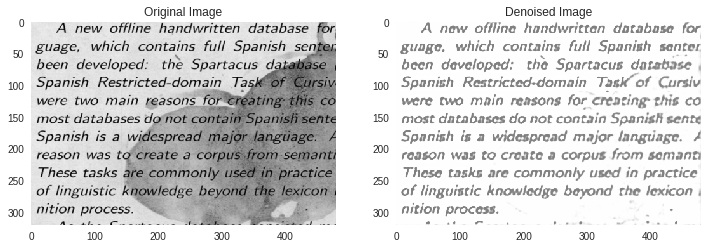

In [18]:
#testing on test set
image = test_images_transformed[-1]
image = image.unsqueeze(0)

if cuda_available:
    image = image.cuda()

output = model(image)

if cuda_available:
    image, output = image.detach().cpu(), output.detach().cpu()
image, output = image.numpy(), output.numpy()

plt.figure(figsize=(12,14))
ax = plt.subplot(1,2,1)
imshow(image[0], ax, 'Original Image')

ax = plt.subplot(1,2,2)
imshow(output[0], ax, 'Denoised Image')

In [0]:
#As you can see in the above image, the autoencoder has given impressive results. The documents noise has been removed 